In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

# Helper modules
Implementation of common CNN blocks used in UNet, normalization and denormalization functions, functions for plotting, and dataset.

In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            # print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani

# UNet

In [3]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels=1, n_feat=64, n_cfeat=10, height=16):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4

        # the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True) # [B, 3, 16, 16] -> [B, 64, 16, 16]

        # the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # [B, 64, 16, 16] -> [B, 64, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # [B, 64, 8, 8] -> [B, 128, 4, 4]

        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU()) # [B, 128, 4, 4] -> [B, 128, 1, 1]

        # embedding layers for the timestep and context labels
        self.timeembed1 = EmbedFC(1, 2*n_feat) # [B, 1] -> [B, 128]
        self.timeembed2 = EmbedFC(1, 1*n_feat) # [B, 1] -> [B, 64]
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat) # [B, 5] -> [B, 128]
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat) # [B, 5] -> [B, 64]

        # the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        ) # [B, 128, 1, 1] -> [B, 128, 4, 4]
        self.up1 = UnetUp(4 * n_feat, n_feat) # [B, 256, 4, 4] -> [B, 64, 8, 8]
        self.up2 = UnetUp(2 * n_feat, n_feat) # [B, 128, 8, 8] -> [B, 64, 16, 16]

        # the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        ) # [B, 128, 16, 16] -> [B, 3, 16, 16]

    def forward(self, x, t, c=None):
        init_conv = None

        # downsampling path
        down1 = None
        down2 = None

        hiddenvec = None

        if c is None:
            c = None

        # embed context and timestep
        cemb1 = None
        temb1 = None
        cemb2 = None
        temb2 = None

        # upsampling path
        up0 = None
        up1 = None
        up2 = None
        out = None
        device = x.device
        x, t = x.to(device), t.to(device)
        init_conv = self.init_conv(x) # [B, 3, 16, 16] -> [B, 64, 16, 16]

        down1 = self.down1(init_conv) # [B, 64, 16, 16] -> [B, 64, 8, 8]
        down2 = self.down2(down1) # [B, 64, 8, 8] -> [B, 128, 4, 4]

        hiddenvec = self.to_vec(down2) # [B, 128, 4, 4] -> [B, 128, 1, 1]

        if c is None:
          c = torch.zeros(x.size(0), self.n_cfeat).to(device)

        cemb1 = self.contextembed1(c) # [B, 5] -> [B, 128]
        temb1 = self.timeembed1(t) # [B, 1] -> [B, 128]
        cemb2 = self.contextembed2(c)  # [B, 5] -> [B, 64]
        temb2 = self.timeembed2(t) # [B, 1] -> [B, 64]


        cemb1 = cemb1.unsqueeze(-1).unsqueeze(-1)
        temb1 = temb1.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 4, 4)
        cemb2 = cemb2.unsqueeze(-1).unsqueeze(-1)
        temb2 = temb2.unsqueeze(-1).unsqueeze(-1)

        up0 = self.up0(hiddenvec) # [B, 128, 1, 1] -> [B, 128, 4, 4]

        up1 = self.up1(up0 * cemb1 + temb1, down2) # [B, 256, 4, 4] -> [B, 64, 8, 8]
        up2 = self.up2(up1 * cemb2 + temb2, down1) # [B, 128, 8, 8] -> [B, 64, 16, 16]
        out = self.out(torch.cat((up2, init_conv), dim=1))
        return out

# hyperparameters

In [4]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = 'cpu'
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 10 # context vector is of size 10
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 10
lrate=1e-3

In [5]:
import torchvision.transforms as transforms, torchvision, matplotlib.pyplot as plt

In [6]:
class addOneHotLable(torch.utils.data.Dataset):
    def __init__(self, dataset, n_cfeat):
        self.dataset = dataset
        self.num_classes = n_cfeat

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=self.num_classes)
        return image, one_hot_label

### MNIST

In [7]:
mnist_pytorch = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize(size=(16,16)), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]))
mnist_one_hot = addOneHotLable(mnist_pytorch, n_cfeat)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4590405.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132771.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1270480.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3744207.70it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
train_loader_pytorch = torch.utils.data.DataLoader(mnist_one_hot, batch_size=batch_size, shuffle=True, num_workers=1)

In [9]:
len(train_loader_pytorch)

600

# DDPM noise schedule

In [10]:
def construct_ddpm_noise(timesteps, beta1, beta2, device):
    beta_t = None
    alpha_t = None
    alpha_bar_t = None
    # the noise schedule for the forward diffusion process
    # https://arxiv.org/pdf/2006.11239.pdf
    diff = (beta2 - beta1) / timesteps
    beta_t = torch.arange(beta1, beta2 + diff, diff)[:timesteps + 1]

    alpha_t = 1 - beta_t

    alpha_bar_t  = np.cumprod(alpha_t)

    alpha_bar_t[0] = 1
    return beta_t, alpha_t, alpha_bar_t

# Training without context

In [19]:
def perturb_input(x, t, noise, alpha_bar_t):
    perturbed_x = None
    # section 3.2 https://arxiv.org/pdf/2006.11239.pdf
    device = x.device
    x, t, noise, alpha_bar_t = x.to(device), t.to(device), noise.to(device), alpha_bar_t.to(device)
    perturbed_x = torch.sqrt(alpha_bar_t[t]) * x + torch.sqrt(1 - alpha_bar_t[t]) * noise

    return perturbed_x

In [11]:
def loss_no_context(x, model, alpha_bar_t, timesteps):
    loss = None
    # loss function as the MSE between predicted and the true noise
    # section 3.4 https://arxiv.org/pdf/2006.11239.pdf
    noise = torch.randn_like(x)

    t = torch.randint(1, timesteps + 1, (x.shape[0],))
    normalized_t = t / timesteps

    # Broadcast t to match the size of x along all dimensions except the batch dimension
    t = t.view(-1, 1, 1, 1).expand(-1, x.shape[1], x.shape[2], x.shape[3])
    # print(t.size())

    perturbed_x = perturb_input(x, t, noise, alpha_bar_t)

    predicted_noise = model(perturbed_x, normalized_t)

    loss = torch.mean((noise - predicted_noise) ** 2)

    return loss

# Sampling

In [12]:
def denoise_add_noise(x, t, pred_noise, alpha_t, beta_t, alpha_bar_t, z=None):
    output = None
    # remove the predicted noise
    # Algorithm 2 https://arxiv.org/pdf/2006.11239.pdf
    # noise (z) to avoid collapse
    if z == None:
      z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)

    sigma_t = torch.sqrt(beta_t)
    sigma_t_z = sigma_t[t] * z
    denoise = beta_t[t] * pred_noise / (torch.sqrt(1 - alpha_bar_t[t]))
    output = 1 / torch.sqrt(alpha_t[t]) * (x - denoise) + sigma_t_z

    return output

In [13]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(model, n_sample, timesteps, alpha_t, beta_t, alpha_bar_t, device='cpu', save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    height = model.h
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        t = None
        z = None
        eps = None

        # Iteratively apply denoising to generate samples.

        z = torch.randn_like(samples) if i > 1 else torch.zeros_like(samples)
        t = torch.tensor(i / timesteps)

        predicted_noise = model(samples, t)

        samples = denoise_add_noise(samples, torch.tensor(i), predicted_noise, alpha_t, beta_t, alpha_bar_t, z)

        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

# Training with context

In [14]:
def loss_with_context(x, c, model, alpha_bar_t, timesteps):
    # randomly mask out c
    device = x.device
    context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
    c = c * context_mask.unsqueeze(-1)

    loss = None

    noise = torch.randn_like(x)

    t = torch.randint(1, timesteps + 1, (x.shape[0],))
    normalized_t = t / timesteps

    t = t.view(-1, 1, 1, 1).expand(-1, x.shape[1], x.shape[2], x.shape[3])

    perturbed_x = perturb_input(x, t, noise, alpha_bar_t)

    predicted_noise = model(perturbed_x, normalized_t, c)
    # loss function as the MSE between predicted and the true noise
    loss = torch.mean((noise - predicted_noise) ** 2)
    return loss

# Sampling with context

In [15]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(model, n_sample, context, timesteps, alpha_t, beta_t, alpha_bar_t, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    height = model.h
    device = context.device
    samples = torch.randn(n_sample, 1, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        t = None
        z = None
        eps = None
        # Iteratively apply denoising to generate samples.        #

        z = torch.randn_like(samples) if i > 1 else torch.zeros_like(samples)
        t = torch.tensor(i / timesteps)

        predicted_noise = model(samples, t, context)

        samples = denoise_add_noise(samples, torch.tensor(i), predicted_noise, alpha_t, beta_t, alpha_bar_t, z)

        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

# Training end-to-end

In [16]:
from IPython.display import HTML

## Without context

In [17]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = 'cpu'
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 10 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 100
lrate=1e-3

In [21]:
# initialize model and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_epoch = 50
nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
b_t, a_t, ab_t = construct_ddpm_noise(timesteps, beta1, beta2, device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(train_loader_pytorch, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)

        loss = loss_no_context(x, nn_model, ab_t, timesteps)
        loss.backward()

        optim.step()

    # save model periodically
    if ep == int(n_epoch-1) or (ep+1)%5 == 0:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


 23%|██▎       | 138/600 [00:08<00:28, 15.95it/s]


KeyboardInterrupt: 

In [ ]:
nn_model.load_state_dict(torch.load(f"{save_dir}/model_49.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

In [ ]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(nn_model, 32, timesteps, a_t, b_t, ab_t, device)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

## With context

In [28]:
# initialize model and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_epoch = 50
nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
b_t, a_t, ab_t = construct_ddpm_noise(timesteps, beta1, beta2, device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    # pbar = tqdm(dataloader, mininterval=2 )
    pbar = tqdm(train_loader_pytorch, mininterval=2 )
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)

        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        loss = loss_with_context(x, c, nn_model, ab_t, timesteps)
        loss.backward()

        optim.step()

    # save model periodically
    if ep == int(n_epoch-1) or (ep+1)%5 == 0:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print('saved model at ' + save_dir + f"context_model_{ep}.pth")

epoch 0


  0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 600/600 [00:30<00:00, 19.54it/s]


epoch 1


100%|██████████| 600/600 [00:29<00:00, 20.11it/s]


epoch 2


100%|██████████| 600/600 [00:28<00:00, 20.81it/s]


epoch 3


100%|██████████| 600/600 [00:28<00:00, 20.88it/s]


epoch 4


100%|██████████| 600/600 [00:29<00:00, 20.15it/s]


saved model at ./weights/context_model_4.pth
epoch 5


100%|██████████| 600/600 [00:29<00:00, 20.38it/s]


epoch 6


100%|██████████| 600/600 [00:30<00:00, 19.69it/s]


epoch 7


100%|██████████| 600/600 [00:31<00:00, 19.25it/s]


epoch 8


100%|██████████| 600/600 [00:28<00:00, 20.71it/s]


epoch 9


100%|██████████| 600/600 [00:27<00:00, 21.61it/s]


saved model at ./weights/context_model_9.pth
epoch 10


100%|██████████| 600/600 [00:28<00:00, 21.07it/s]


epoch 11


100%|██████████| 600/600 [00:28<00:00, 21.18it/s]


epoch 12


100%|██████████| 600/600 [00:27<00:00, 21.54it/s]


epoch 13


100%|██████████| 600/600 [00:27<00:00, 21.57it/s]


epoch 14


100%|██████████| 600/600 [00:30<00:00, 19.71it/s]


saved model at ./weights/context_model_14.pth
epoch 15


100%|██████████| 600/600 [00:27<00:00, 21.49it/s]


epoch 16


100%|██████████| 600/600 [00:27<00:00, 21.89it/s]


epoch 17


100%|██████████| 600/600 [00:27<00:00, 21.98it/s]


epoch 18


100%|██████████| 600/600 [00:27<00:00, 21.87it/s]


epoch 19


100%|██████████| 600/600 [00:27<00:00, 21.85it/s]


saved model at ./weights/context_model_19.pth
epoch 20


100%|██████████| 600/600 [00:27<00:00, 22.16it/s]


epoch 21


100%|██████████| 600/600 [00:27<00:00, 21.82it/s]


epoch 22


100%|██████████| 600/600 [00:29<00:00, 20.03it/s]


epoch 23


100%|██████████| 600/600 [00:28<00:00, 21.30it/s]


epoch 24


100%|██████████| 600/600 [00:27<00:00, 21.47it/s]


saved model at ./weights/context_model_24.pth
epoch 25


100%|██████████| 600/600 [00:27<00:00, 21.53it/s]


epoch 26


100%|██████████| 600/600 [00:28<00:00, 20.83it/s]


epoch 27


100%|██████████| 600/600 [00:28<00:00, 21.40it/s]


epoch 28


100%|██████████| 600/600 [00:27<00:00, 21.50it/s]


epoch 29


100%|██████████| 600/600 [00:28<00:00, 20.94it/s]


saved model at ./weights/context_model_29.pth
epoch 30


100%|██████████| 600/600 [00:28<00:00, 20.71it/s]


epoch 31


100%|██████████| 600/600 [00:29<00:00, 20.51it/s]


epoch 32


100%|██████████| 600/600 [00:28<00:00, 20.95it/s]


epoch 33


100%|██████████| 600/600 [00:27<00:00, 21.81it/s]


epoch 34


100%|██████████| 600/600 [00:28<00:00, 20.78it/s]


saved model at ./weights/context_model_34.pth
epoch 35


100%|██████████| 600/600 [00:29<00:00, 20.00it/s]


epoch 36


100%|██████████| 600/600 [00:29<00:00, 20.11it/s]


epoch 37


100%|██████████| 600/600 [00:29<00:00, 20.34it/s]


epoch 38


100%|██████████| 600/600 [00:30<00:00, 19.73it/s]


epoch 39


100%|██████████| 600/600 [00:29<00:00, 20.49it/s]


saved model at ./weights/context_model_39.pth
epoch 40


100%|██████████| 600/600 [00:30<00:00, 19.65it/s]


epoch 41


100%|██████████| 600/600 [00:29<00:00, 20.37it/s]


epoch 42


100%|██████████| 600/600 [00:28<00:00, 20.80it/s]


epoch 43


100%|██████████| 600/600 [00:29<00:00, 20.46it/s]


epoch 44


100%|██████████| 600/600 [00:29<00:00, 20.02it/s]


saved model at ./weights/context_model_44.pth
epoch 45


100%|██████████| 600/600 [00:28<00:00, 20.78it/s]


epoch 46


100%|██████████| 600/600 [00:30<00:00, 19.66it/s]


epoch 47


100%|██████████| 600/600 [00:29<00:00, 20.34it/s]


epoch 48


100%|██████████| 600/600 [00:30<00:00, 19.40it/s]


epoch 49


100%|██████████| 600/600 [00:29<00:00, 20.11it/s]


saved model at ./weights/context_model_49.pth


In [29]:
# load in pretrain model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/context_model_49.pth", map_location=device))
nn_model.eval()
print("Loaded in Context Model")

Loaded in Context Model


In [30]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(0, 10, (32,)), 10).to(device=device).float()
samples, intermediate = sample_ddpm_context(nn_model, 32, ctx, timesteps, a_t, b_t, ab_t)
animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [32]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]], device='cuda:0')

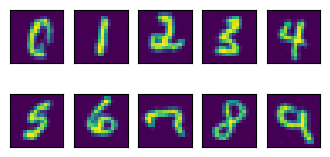

In [44]:
# pre-defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1],
]).float().to(device)

samples, _ = sample_ddpm_context(nn_model, ctx.shape[0], ctx, timesteps, a_t, b_t, ab_t)
show_images(samples)